# Toxic comments - Iteration # 5

### Date: 11th Dec 2020
Sherry

The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [2]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [ ]:
help(BinaryClassificationPerformance)

# Function for feature building and extraction on natural language data

#### Changes made to feature building and extraction:
  1. **added bigrams and custom stopwords**
  
        `hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False, ngram_range=(1,2), stop_words = new_stop_words)`
        
        
  2. **added smooth_idf parameter as False**
  
        `TfidfTransformer(smooth_idf=False)`
        
        
  3. **Added two features: question counts and exclamation counts**
            `toxic_data['exclaim_count'] = toxic_data['comment_text'].str.count("\!")`
            `toxic_data['quest_count'] = toxic_data['comment_text'].str.count("\?")`
       

In [114]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())
        
    #custom stopwords Kavita Ganesan from https://github.com/kavgan/nlp-in-practice/blob/master/tf-idf/resources/stopwords.txt     
    new_stop_words = open('stopwords.txt','r').read().split('\n')

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
#         hv = HashingVectorizer(n_features=2 ** 13, alternate_sign=False, strip_accents = 'ascii', ngram_range=(3,5), stop_words='english', analyzer = 'word')
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False, ngram_range=(1,2), stop_words = new_stop_words)
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer(smooth_idf=False)
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['exclaim_count'] = toxic_data['comment_text'].str.count("\!")
    toxic_data['quest_count'] = toxic_data['comment_text'].str.count("\?")

    
#     toxic_data['allcaps_count'] = toxic_data['comment_text'].str.findall(r'[A-Z]').str.len()

#     X_quant_features = toxic_data[["word_count", "exclaim_count", "allcaps_count"]]
    X_quant_features = toxic_data[["word_count", "exclaim_count", "quest_count"]]
#     X_quant_features = toxic_data[["word_count", "exclaim_count"]]


    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.0000001, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [115]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='../../data/toxiccomments_train.csv', my_random_seed=1999)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

/Users/smanzar/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['come', 'vis', 'viser', 'visest'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Shape of HashingVectorizer X:
(159571, 131072)
Look at a few rows of the new quantitative features: 
   word_count  exclaim_count  quest_count
0          42              0            1
1          18              1            0
2          42              0            0
3         112              0            0
4          13              0            1
5          12              0            0
6           8              0            0
7          21              0            0
8          83              0            1
9          12              0            0
Size of combined bag of words and new quantitative variables matrix:
(159571, 131075)
(159571, 131075)
Shape of X_train and X_test:
(159570, 131075)
(1, 131075)
Shape of y_train and y_test:
(159570,)
(1,)
Shape of X_raw_train and X_raw_test:
(159570, 12)
(1, 12)
SUCCESS!
Number of fits stored in `fitted_transformations` list: 
3


# Fit (and tune) Various Models

### MODEL: Naive Bayes

In [116]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB(alpha=0.01)
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 16225, 'Neg': 143345, 'TP': 15794, 'TN': 135442, 'FP': 7903, 'FN': 431, 'Accuracy': 0.9477721376198533, 'Precision': 0.6664978689285563, 'Recall': 0.9734360554699538, 'desc': 'nbs_train'}


In [117]:
from sklearn.naive_bayes import ComplementNB
nb_c = ComplementNB(alpha=580, norm=True)
nb_c.fit(X_train, y_train)

nb_c_performance_train = BinaryClassificationPerformance(nb_c.predict(X_train), y_train, 'nb_c_train')
nb_c_performance_train.compute_measures()
print(nb_c_performance_train.performance_measures)

{'Pos': 16225, 'Neg': 143345, 'TP': 15145, 'TN': 134150, 'FP': 9195, 'FN': 1080, 'Accuracy': 0.9356081970295168, 'Precision': 0.6222267871815941, 'Recall': 0.9334360554699538, 'desc': 'nb_c_train'}


### MODEL: SVM-C

In [118]:
from sklearn.svm import LinearSVC
svmc_0002 = LinearSVC(loss='squared_hinge', C=0.0002)
svmc_0002.fit(X_train, y_train)

svmc_0002_performance_train = BinaryClassificationPerformance(svmc_0002.predict(X_train), y_train, 'svmc_0002_train')
svmc_0002_performance_train.compute_measures()
print(svmc_0002_performance_train.performance_measures)

{'Pos': 16225, 'Neg': 143345, 'TP': 16194, 'TN': 143325, 'FP': 20, 'FN': 31, 'Accuracy': 0.9996803910509494, 'Precision': 0.998766498088072, 'Recall': 0.9980893682588597, 'desc': 'svmc_0002_train'}


### MODEL: Ridge Regression Classifier

#### Changes made to ridge regression classifier:

  1. **change alphas to 800, 50, 30, 20, 25, 35, 50000**
  
          
  2. **added normalization parameter and changed the solver to the SAG methodology**
  
        `normalize=True, solver='sag'`
        
        This doesn't work on higher alphas though - error of scalars
        
       

#### MODEL: Ridge Regression Classifier (alpha = 800)

In [119]:
from sklearn import linear_model


rdg_800 = linear_model.RidgeClassifier(alpha = 800, normalize=True, solver='sag')
rdg_800.fit(X_train, y_train)

rdg_800_performance_train = BinaryClassificationPerformance(rdg_800.predict(X_train), y_train, 'rdg_800_train')
rdg_800_performance_train.compute_measures()
print(rdg_800_performance_train.performance_measures)

/Users/smanzar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


{'Pos': 16225, 'Neg': 143345, 'TP': 12872, 'TN': 142407, 'FP': 938, 'FN': 3353, 'Accuracy': 0.9731089803847841, 'Precision': 0.9320782041998552, 'Recall': 0.7933436055469953, 'desc': 'rdg_800_train'}


#### MODEL: Ridge Regression Classifier (alpha = 50)

In [120]:
rdg_50 = linear_model.RidgeClassifier(alpha = 50, normalize=True, solver='sag')
rdg_50.fit(X_train, y_train)

rdg_50_performance_train = BinaryClassificationPerformance(rdg_50.predict(X_train), y_train, 'rdg_50_train')
rdg_50_performance_train.compute_measures()
print(rdg_50_performance_train.performance_measures)

/Users/smanzar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


{'Pos': 16225, 'Neg': 143345, 'TP': 15774, 'TN': 134027, 'FP': 9318, 'FN': 451, 'Accuracy': 0.9387792191514696, 'Precision': 0.6286465805834529, 'Recall': 0.9722033898305085, 'desc': 'rdg_50_train'}


#### MODEL: Ridge Regression Classifier (alpha = 30)

In [121]:
from sklearn import linear_model
rdg_30 = linear_model.RidgeClassifier(alpha = 30, normalize=True, solver='sag')
rdg_30.fit(X_train, y_train)

rdg_30_performance_train = BinaryClassificationPerformance(rdg_30.predict(X_train), y_train, 'rdg_30_train')
rdg_30_performance_train.compute_measures()
print(rdg_30_performance_train.performance_measures)

/Users/smanzar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


{'Pos': 16225, 'Neg': 143345, 'TP': 15913, 'TN': 132570, 'FP': 10775, 'FN': 312, 'Accuracy': 0.9305195212132606, 'Precision': 0.5962604916067147, 'Recall': 0.9807704160246533, 'desc': 'rdg_30_train'}


#### MODEL: Ridge Regression Classifier (alpha = 20)

In [122]:
from sklearn import linear_model
rdg_20 = linear_model.RidgeClassifier(alpha = 20, normalize=True, solver='sag')
rdg_20.fit(X_train, y_train)

rdg_20_performance_train = BinaryClassificationPerformance(rdg_20.predict(X_train), y_train, 'rdg_20_train')
rdg_20_performance_train.compute_measures()
print(rdg_20_performance_train.performance_measures)

/Users/smanzar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


{'Pos': 16225, 'Neg': 143345, 'TP': 16014, 'TN': 131284, 'FP': 12061, 'FN': 211, 'Accuracy': 0.9230933132794384, 'Precision': 0.5704007123775601, 'Recall': 0.9869953775038521, 'desc': 'rdg_20_train'}


#### MODEL: Ridge Regression Classifier (alpha = 25)

In [123]:
from sklearn import linear_model
rdg_25 = linear_model.RidgeClassifier(alpha = 25, normalize=True, solver='sag')
rdg_25.fit(X_train, y_train)

rdg_25_performance_train = BinaryClassificationPerformance(rdg_25.predict(X_train), y_train, 'rdg_25_train')
rdg_25_performance_train.compute_measures()
print(rdg_25_performance_train.performance_measures)

/Users/smanzar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


{'Pos': 16225, 'Neg': 143345, 'TP': 15962, 'TN': 131998, 'FP': 11347, 'FN': 263, 'Accuracy': 0.9272419627749577, 'Precision': 0.5844959537148925, 'Recall': 0.9837904468412944, 'desc': 'rdg_25_train'}


#### MODEL: Ridge Regression Classifier (alpha = 35)

In [124]:
from sklearn import linear_model
rdg_35 = linear_model.RidgeClassifier(alpha = 35, normalize=True, solver='sag')
rdg_35.fit(X_train, y_train)

rdg_35_performance_train = BinaryClassificationPerformance(rdg_35.predict(X_train), y_train, 'rdg_35_train')
rdg_35_performance_train.compute_measures()
print(rdg_35_performance_train.performance_measures)

/Users/smanzar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


{'Pos': 16225, 'Neg': 143345, 'TP': 15881, 'TN': 133035, 'FP': 10310, 'FN': 344, 'Accuracy': 0.9332330638591214, 'Precision': 0.6063533274789049, 'Recall': 0.9787981510015409, 'desc': 'rdg_35_train'}


#### MODEL: Ridge Regression Classifier (alpha = 50000)

In [125]:
from sklearn import linear_model
rdg_50000 = linear_model.RidgeClassifier(alpha = 50000)
rdg_50000.fit(X_train, y_train)

rdg_50000_performance_train = BinaryClassificationPerformance(rdg_50000.predict(X_train), y_train, 'rdg_50000_train')
rdg_50000_performance_train.compute_measures()
print(rdg_50000_performance_train.performance_measures)

{'Pos': 16225, 'Neg': 143345, 'TP': 15723, 'TN': 143309, 'FP': 36, 'FN': 502, 'Accuracy': 0.9966284389296234, 'Precision': 0.9977155910908052, 'Recall': 0.969060092449923, 'desc': 'rdg_50000_train'}


### ROC plot to compare performance of various models and fits

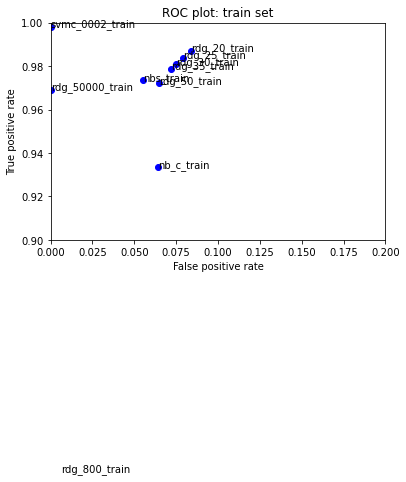

In [126]:
# fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]
# fits = [svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train]
# fits = [svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_50_performance_train, svmc_0002_performance_train, rdg_800_performance_train, rdg_50000_performance_train]
fits = [svmc_0002_performance_train, nbs_performance_train, nb_c_performance_train, rdg_50_performance_train,rdg_30_performance_train,rdg_20_performance_train, rdg_25_performance_train, rdg_35_performance_train, rdg_800_performance_train, rdg_50000_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 0.2, 0.9, 1])
plt.title('ROC plot: train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [19]:
rdg_predictions = rdg_25.predict(X_train)

In [81]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(rdg_predictions)):
    if (rdg_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
153
"

Regarding the statement:
""Prize money for Thailand Division 1 League (season 2006) has been missing. Royal Thai Police FC, the winner of the season told the press to sue the FAT.""

Is it possible the correct line should be""......Royal Thai Police FC, the winner of the season told the press they would sue the FAT.""?
This is important, as it changes the meaning greatly.
  "
* * * * * * * * * 
412
My plan worked
Ha, ha! My plan to get my brother, User:JohnnyAlbert10 out of wikipedia worked.
* * * * * * * * * 
644
The user denied making the edit (not true).
* * * * * * * * * 
820
Tea leaves OR dust from a ripped open bag?

This seems very odd.  How could mere dust from a ripped open bag be an alternative to tea leaves?
* * * * * * * * * 
892
"
I guess I don't know what a high-rise building is, and my grammar is just stupid. I am very embarrassed. I will not be creating new articles, I am sincerely sorry  - I really do try to help Wikipedia, but I am 

15865
CAN I ASK WHY THIS 'C. FRED' DUDE IS ALL OVER BABY GIRL'S ARTICLE LIKE IF HE'S A FAN???????
* * * * * * * * * 
15949
REDIRECT Talk:Jo's Boys (anime)
* * * * * * * * * 
16152
Another laughable British project doomed to the dust bin.  HOTOL, TSR Nimrod AEW, Beagle 2  somebody stop me!
* * * * * * * * * 
16341
Oh Sorry mate, It just happened by mistake. Cheers
* * * * * * * * * 
16432
Genres 

Hi, I think Thrash Metal should be kept because the album is thrash metal even if it is only in very small doses and the Sputnik Music review references it as such.
* * * * * * * * * 
16753
So - what do you choose, delete this sentence or rename the article?
* * * * * * * * * 
17186
I have given a perfectly good reason. You are wasting everyone's time.
* * * * * * * * * 
17276
It's khoikhoi

that sock is Mr Putnam alias Khoikhoi, I'm also jew but this hungarian jew is an anti-romanian one
* * * * * * * * * 
17754
"Incidentally Persians In Tehran are immigrants. tehran by turk qajar was a capit

32690
I'm a Jew, so I don't believe in hell, but thanks for playing.
* * * * * * * * * 
32720
Yeah stop deleting and changing things you dont agree with
* * * * * * * * * 
32795
"

 RE 

I can't believe I'm having this conversation with somebody who believes global warming is a myth. Look, I was trying to warn you that sending someone links to pages on ""how to edit wikipedia for beginners"" when they have made a mistake with AWB - surely that alone shows that they aren't some idiot - is not going to get you many friends.   "
* * * * * * * * * 
33178
You really ought to do what you'll do anyway, which is to have me barred completely. This is how Wikipedia operates. As for you, if I'm not mistaken there are two people who have lost their jobs because of the good you've done. Merry Christmas! Does it make you feel good to know that you took away people's livelihoods? Give you a thrill, does it?
* * * * * * * * * 
33204
2008 (UTC)
Om Namah Shivaya. Om Namah Shivaya. Om Namah Shivaya. May 

45371
User:They call me Mr. Pibb
* * * * * * * * * 
45595
Migit wrestler 

Why does it have to say that? Why cant it say dwarf or little person? Calling a dwarf a migit is a) rude and b) WRONG (PEOPLE ARENT SUPPOSE TO SAY IT)
* * * * * * * * * 
46139
hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey
* * * * * * * * * 
47215
"

You say I should calm down, but when I read the attacks against this article by you and all your buddies, I knew I didn't have a snowball's chance in hell of saving it.

What am I supposed to do? Get TIME MAGAZINE to feature it?

Your page on notable sources is too wordy and a lot of blah, blah, blah! very vague!

Let's have it in a nutshell already!

also, who are you people (HONESTLY) to say whether or not this will

60303
Kyle went to Hunter College High School, see that WIKI page. -yours truly, MY point is that denying the public info is a very sublimely diabolical act as it hurts the poor MUCH more than the affluent, cuz the rich usually have a wider circle of friends & know the info thru 'word of mouth' ...trust me, I know, my father was a janitor
* * * * * * * * * 
60305
in the anime she had a true star seed and was a senshi but never transformed probly
* * * * * * * * * 
60403
"

 One More Love Booklet, does anyone have it?  

please? • You Da One "
* * * * * * * * * 
60536
another way if you don't mind.
* * * * * * * * * 
61116
even though they are from Dublin
* * * * * * * * * 
61204
so 3 reverts is allowed but 4 reverts isnt? am i allowed to edit if its not a revert?
* * * * * * * * * 
61222
Under no circumstances should this discussion be deleted, let it remain as a testament to the stupidity of the vocal few and so Wikipedians know who the anti-Semites are at the Wiki.
* * * * * * * * * 

78701
"

Thanks for correcting my screw-up about ""through""!  Good to learn about Wikipedia stylistics.  Best,   "
* * * * * * * * * 
78782
One by one, instead of looking at whos the culprit, you are teaching me WP:civility? teach yourself! 108.78.177.132
* * * * * * * * * 
78938
, pompous and abusing the little authority I have, I enjoy my same sex
* * * * * * * * * 
79184
From Riverside to Michigan. What a big change, eh? I don't many people that do that.
* * * * * * * * * 
79222
"
Unlucky 13th; it just had to be that game for your run to end. (talk) "
* * * * * * * * * 
79356
You can prove all of this definitively?  24.255.11.149
* * * * * * * * * 
79380
DreamGuy
why do you undo everything i do on The Blackout Ripper ?
* * * * * * * * * 
79415
Probably they weren't watching WWE at all... All they do here is ban. Those who have power abuse that power, but like I said, they can't stop them all... The truth shall set you free. Lita DDT, Lita Bomb, and Litasault are correct terms for h

91697
haha it is soo funny
and thats why im keeping it on the page.
* * * * * * * * * 
91875
Auburn 

Why do you hate Auburn so much? All because you hate AU, doesn't mean you can vandalize Auburn's wiki.
* * * * * * * * * 
91924
Probably the Player's Handbook, although I don't have it handy at the moment. 75.149.195.214
* * * * * * * * * 
92058
Patricia Columbo 

I know you guys all do the power trip thing, but the things you deleted from Patricia Columbo page were all referenced and were all approved by moderator Chock Bowen.  Do you guys even check before you swoop in and delete?  Guess not.   ColScott
* * * * * * * * * 
92334
Rather than get all bent out of shape on the AfD page, why not read up on our standards?
* * * * * * * * * 
92529
I had little to do with the ;
* * * * * * * * * 
93056
And a lot of Basques like me consider themselves Spaniards, in spite of the fact that we have to live with the harrassment of one of the most violent minorities in Europe, the extreme Basque na

103721
I'm involved in this content dispute?  Hell, I don't even understand what this article is about!  Something to do with ancient Greek, but beyond that, I've no clue.
* * * * * * * * * 
104151
BBB is an information nazi
* * * * * * * * * 
104461
Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block Block

116389
-Thank God, or we might still hear more of his crap.
* * * * * * * * * 
116522
Waseem Akhtar 

That was a spectacularly bad speedy deletion nomination   not?
* * * * * * * * * 
116637
Could you hold up for 5 minutes ? 

Could you hold up for 5 minutes until I get rest of the sections split off?
* * * * * * * * * 
117065
"

 Possible Troll 

Why is the word ""MONKEY"" at the bottom of this?"
* * * * * * * * * 
117092
I am not really against that.
* * * * * * * * * 
117499
FINE! How about you tell me what contribution of yours I am to talk about?  You have made no contribution at all except to delete my post...which is no contribution at all.  Why is it that the people who make something are unreliable, but someone who just learns about that something from the creator and then makes an article about it is reliable?  That makes absolutely no sense at all.  I hope you are glad that you have lost a potential contributor to this site and I will do everything I can to make sure that ev

130045
Relax guy 
Randy Jilek is making me write all these bad things.
* * * * * * * * * 
130738
why do you care?? 

tell me just tell me
* * * * * * * * * 
131254
wikipedia is only open to 10 year old boys.
* * * * * * * * * 
131335
info for your curiosity

Credibility_node_ue
* * * * * * * * * 
131649
When did I remove things from talk pages? 122.105.217.56
* * * * * * * * * 
132276
"

""You should use personal attacks or rudeness here."" I agree.  "
* * * * * * * * * 
132956
It didn't take as long to revert it as you thought it would. If you're such a good editor, why add vandalism? And if you want it be a bad ass rebel, you've failed by being coward enough to only put vandalism on an obscure page. Unluckily for you, I prowl the incumbent heads of state and government articles.
* * * * * * * * * 
133523
Re the above: Waaaaaaaaaaaaah 72.37.171.100
* * * * * * * * * 
133569
"

Would you just do me a favor though and stop harassing me! I have reported you, and there will be something c

143225
Narihira in setsuwa literature
Narihira was a recurring figure in later tale (setsuwa) literature.
* * * * * * * * * 
143689
Note 

Note that 86.181.11.197 is available to the public.
* * * * * * * * * 
144180
Because I think you are a puppet account of  Talk
* * * * * * * * * 
144779
The above is defamation. I don't know who is CYl7EPTEMA777.  Epipelagic is a habitual liar, his lie has been documented in many places. For example here
* * * * * * * * * 
144899
...No actually, it was racist. I politely request that nobody with an ideology I consider racist posts to my talk page. I'll assume you are racist until I see evidence otherwise.
* * * * * * * * * 
145030
REDIRECT Talk:Topal Izzet Mehmed Pasha
* * * * * * * * * 
145087
Yes, this the wrong picture.  The first Coca-Cola bottles were Hutchinson bottles.
* * * * * * * * * 
145126
Have you seen this? 

Tony, Have you seen this? —
* * * * * * * * * 
146239
"""free source"" train, keep safety in mind. And finally the reminder. It

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

In [127]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 0, 'Neg': 1, 'TP': 0, 'TN': 1, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': nan, 'Recall': nan, 'desc': 'nbs_test'}


/Users/smanzar/Documents/Grad school/New School/Fall 2020/ml/final_assignment_1/iterations/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])
/Users/smanzar/Documents/Grad school/New School/Fall 2020/ml/final_assignment_1/iterations/my_measures.py:26: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Recall'] = self.performance_measures['TP'] / self.performance_measures['Pos']


In [128]:
nb_c_performance_test = BinaryClassificationPerformance(nb_c.predict(X_test), y_test, 'nbc_test')
nb_c_performance_test.compute_measures()
print(nb_c_performance_test.performance_measures)

{'Pos': 0, 'Neg': 1, 'TP': 0, 'TN': 1, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': nan, 'Recall': nan, 'desc': 'nbc_test'}


/Users/smanzar/Documents/Grad school/New School/Fall 2020/ml/final_assignment_1/iterations/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])
/Users/smanzar/Documents/Grad school/New School/Fall 2020/ml/final_assignment_1/iterations/my_measures.py:26: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Recall'] = self.performance_measures['TP'] / self.performance_measures['Pos']


In [129]:
svmc_0002_performance_test = BinaryClassificationPerformance(svmc_0002.predict(X_test), y_test, 'svm_test')
svmc_0002_performance_test.compute_measures()
print(svmc_0002_performance_test.performance_measures)

{'Pos': 0, 'Neg': 1, 'TP': 0, 'TN': 1, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': nan, 'Recall': nan, 'desc': 'svm_test'}


/Users/smanzar/Documents/Grad school/New School/Fall 2020/ml/final_assignment_1/iterations/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])
/Users/smanzar/Documents/Grad school/New School/Fall 2020/ml/final_assignment_1/iterations/my_measures.py:26: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Recall'] = self.performance_measures['TP'] / self.performance_measures['Pos']


In [130]:
rdg_20_performance_test = BinaryClassificationPerformance(rdg_20.predict(X_test), y_test, 'rdg_20_test')
rdg_20_performance_test.compute_measures()
print(rdg_20_performance_test.performance_measures)

{'Pos': 0, 'Neg': 1, 'TP': 0, 'TN': 1, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': nan, 'Recall': nan, 'desc': 'rdg_20_test'}


/Users/smanzar/Documents/Grad school/New School/Fall 2020/ml/final_assignment_1/iterations/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])
/Users/smanzar/Documents/Grad school/New School/Fall 2020/ml/final_assignment_1/iterations/my_measures.py:26: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Recall'] = self.performance_measures['TP'] / self.performance_measures['Pos']


<ipython-input-131-3daa7999c0fb>:10: RuntimeWarning: invalid value encountered in long_scalars
  fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
<ipython-input-131-3daa7999c0fb>:12: RuntimeWarning: invalid value encountered in long_scalars
  fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


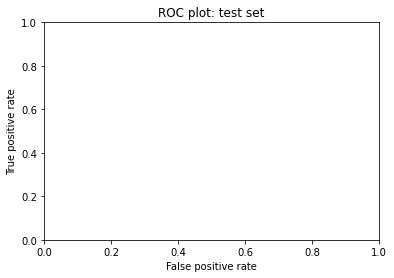

<ipython-input-131-3daa7999c0fb>:25: RuntimeWarning: invalid value encountered in long_scalars
  fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
<ipython-input-131-3daa7999c0fb>:27: RuntimeWarning: invalid value encountered in long_scalars
  fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


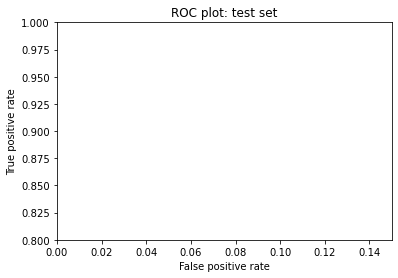

In [131]:
# fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]
# fits = [svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]
# fits = [svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test]
# fits = [svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_800_performance_test, rdg_50000_performance_test, rdg_50_performance_test, svmc_0002_performance_test]
fits = [nb_c_performance_test, svmc_0002_performance_test, nbs_performance_test, rdg_20_performance_test]


for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

# fits_small = [svm_performance_test, rdg_50_performance_test, rdg_30_performance_test,rdg_20_performance_test, rdg_25_performance_test, rdg_35_performance_test, rdg_800_performance_test, svmc_0002_performance_test]
fits_small = [nb_c_performance_test, svmc_0002_performance_test, nbs_performance_test, rdg_20_performance_test]


for fit in fits_small:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 0.15, 0.8, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [134]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='../../data/toxiccomments_test.csv', my_random_seed=1999, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 131072)
Look at a few rows of the new quantitative features: 
   word_count  exclaim_count  quest_count
0          72              0            0
1          13              0            0
2          16              0            0
3          38              0            0
4           7     

### Prepare ensemble

In this iteration, I am choosing the **Ensemble VotingClassifier (Naive Bayes and Ridge )** model fit, which is in the `esb` object. 

In [135]:
from sklearn.ensemble import VotingClassifier
estimators = [('nb_c', nb_c), ('rdg', rdg_20)]
esb = VotingClassifier(estimators, voting='hard', weights =['1', '3'])
esb.fit(X_train, y_train)

esb_performance_train = BinaryClassificationPerformance(esb.predict(X_train), y_train, 'esb_train')
esb_performance_train.compute_measures()
print(esb_performance_train.performance_measures)


/Users/smanzar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


{'Pos': 16225, 'Neg': 143345, 'TP': 16015, 'TN': 131294, 'FP': 12051, 'FN': 210, 'Accuracy': 0.9231622485429593, 'Precision': 0.5706192546141239, 'Recall': 0.9870570107858243, 'desc': 'esb_train'}


---
I will now manually combine the predictions of `rdg`, `nb_c` and `svmc` to make the final predictions

In [137]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction_1"] = rdg_20.predict(X_test_submission)

# my_submission["prediction_2"] = nbs.predict(X_test_submission)

my_submission["prediction_3"] = nb_c.predict(X_test_submission)

my_submission["prediction_4"] = svmc_0002.predict(X_test_submission)

# my_submission["prediction_5"] = esb.predict(X_test_submission)

my_submission["prediction"] = my_submission[["prediction_1","prediction_3", "prediction_4"]].sum(axis=1) >= 1


In [139]:
# my_submission.head(40)
# store the id from the raw data
# my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
# my_submission["prediction"] = esb.predict(X_test_submission)

# look at the proportion of positive predictions
print(my_submission['prediction'].mean())


0.36210858948577995


In [140]:
raw_data.head()

,id,comment_text,word_count,exclaim_count,quest_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,0,0
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,0,0
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,0,0
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,0,0


In [141]:
my_submission.head()

,id,prediction_1,prediction_3,prediction_4,prediction
0,00001cee341fdb12,True,True,False,True
1,0000247867823ef7,False,False,False,False
2,00013b17ad220c46,False,True,False,True
3,00017563c3f7919a,False,False,False,False
4,00017695ad8997eb,False,False,False,False


In [142]:
my_submission.shape

(153164, 5)

In [144]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('submission/toxiccomments_submission_iter_5.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation